## SI model on network with Monte Carlo Simulations

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.generators.random_graphs import erdos_renyi_graph
import pandas as pd
import numpy as np
import random
import statistics

Build up a network. Remove # and adjust the parameters to build up different networks.

average node degree is 10.0


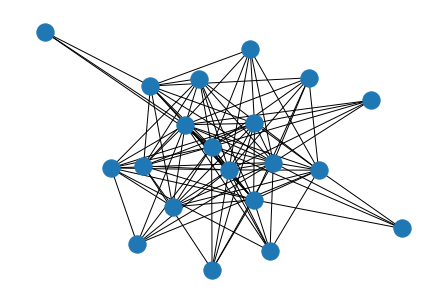

In [43]:
#small world network(Preferential attachment)
#with 20 nodes with average 10 node degree
G= nx.barabasi_albert_graph(n=20, m=10, seed=None, initial_graph=None)  
                                                                         
#random graph, with 20 nodes and 0.4 proabability 
#of reaching out an edge
#G = erdos_renyi_graph(20,0.4)                                           
                                                                         
#Complete graph, 20 nodes.   
#G= nx.complete_graph(20, create_using=None)                             
nx.draw_spring(G);

A = nx.adjacency_matrix(G)
Adj =A.todense()
degrees = [G.degree(n) for n in G.nodes()]
averg=np.sum(degrees)/len(Adj)
print('average node degree is',averg)

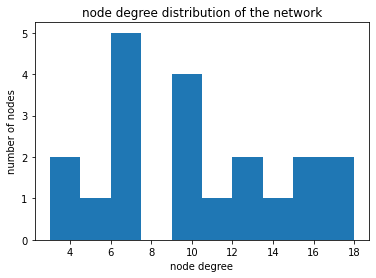

In [44]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()
    
plt.xlabel('node degree')
plt.ylabel('number of nodes')
plt.title('node degree distribution of the network')
plot_degree_dist(G)

With one network and SI infection model, we have 2 updating methods and 2 decision making process.
So total 4 different mechanisms:
1. Synchronous update + Fixed threshold (deterministic)
2. Synchronous update + Random probabilistic variable (Stochastics)
3. Asynchronous update(Stochastics) + Fixed threshold 
4. Asynchronous update(Stochastics) + Random probabilistic variable (Stochastics)

More information on updating methods:

Synchronous update:
At each time step, update all nodes based on their neighbors, store the data and update them all at the last step.

Asynchronous update:
At each time step, randomly choose one node to get updated by the stochastic SI network model. 

More information on decision-making process:

Fixed threshold: 
Once node i’s probability of getting infectious is over the Fixed threshold (a constant that we define between [0,1]), 
we assume that node i is at an “infected” state.

Random probabilistic variable:
First generate a random number within range [0,1], uniformly distributed. If this number falls into the range 
[0, probability of getting infectious of node i], we assume that node i is at an “infected” state. 

All nodes that are already in an “infected” state cannot be influenced by their neighbors furthermore, but can continuously influence their neighbors who have not yet been in an “infected” state. Also, the probability of getting infectious accumulates until it reaches an “infected” state.


## Case 1: Synchronous update + Fixed threshold (deterministic)

In [56]:
dt= 0.0001 #timestep
beta = 0.3 #constant infectious rate
threshold = 0.5 # Fixed threshold 
                #If node i's proability of being infectious is over the threshold,
                #we consider node i is 100% infectious.
        
Ini=random.randint(0, len(Adj)-1) #randomly chose 1 node in the whole network
print('random chose node number',Ini,'to be 100% infectious')
print('the node degree for this random chosen node is',G.degree(Ini))

random chose node number 5 to be 100% infectious
the node degree for this random chosen node is 10


Difference equation (probabilistic) used below: probability of infectious for node i at time (t+delta t) = (probability of infectious for node i at time t)+ (constant infectious rate)x(probability of susceptable rate for node i at time t)x (delta t)

Text(0, 0.5, 'total infectious people')

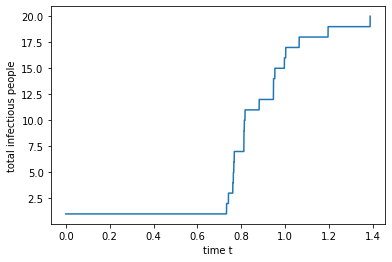

In [57]:
prb_infec = [0] * len(Adj)        #probability of infectious array for all nodes at time 0 
prb_infec[Ini]=1                 #one randomly picked infected person with infectious rate 100 percent 
time_step = 0
seq = [0]*1
temp = [0]*len(Adj)
while min(prb_infec)<threshold:
    time_step = time_step+1
    for i in range(len(Adj)):
        if prb_infec[i]==1:
            temp[i]=1 
        elif prb_infec[i]!=1:
            influence = 0
            for j in range(len(Adj)):
                influence = influence + (Adj[i,j]*prb_infec[j])
            temp[i]= prb_infec[i]+ (beta*(1-prb_infec[i])*influence*dt)
    
            if temp[i] > threshold and node_number!=Ini:     
                temp[i]=1             
                seq.append(time_step)             
                 
    for i in range(len(Adj)):           #update all node's probability of infectious at the end of                            
        prb_infec[i]=temp[i]            #one time step. Will throw away nodes whose probability
                                        #of infectious is 100%.

t_size = max(seq)+1
time_array=np.arange(0, t_size*dt, dt).tolist()
count = [-1]*(t_size)
for i in range(t_size):
    count[i]=seq.count(i) 
sum = 0
for i in range(len(count)):
    count[i]=count[i]+sum
    sum = count[i]
plt.plot(time_array,count)
plt.xlabel("time t")
plt.ylabel("total infectious people")

Compute waiting time of getting newly infected people, and compute 
variance & expectation^2 (they should be same is the distribution were exponential)

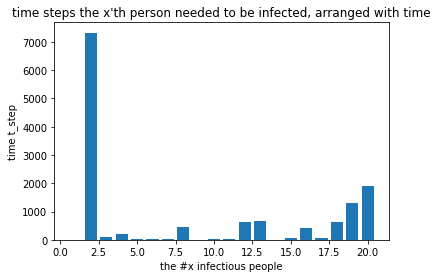

variance of waiting time is 0.028114888771929823
expectation^2 of waiting time is 0.0053305369529085865


In [59]:
nodes = list(range(1, len(Adj)+1))
dif= [0]
for i in range(len(Adj)-1):
    time_dif = seq[i+1]-seq[i]
    dif.append(time_dif)
his = (nodes,dif)
plt.bar(*his)
plt.ylabel("time t_step")
plt.xlabel("the #x infectious people")
plt.title("time steps the x'th person needed to be infected, arranged with time")
plt.show()
if dif.count(0) >1:
    print("more than one event occur at one time step, shrink dt and try again")
dif.remove(0)

time_list = np.zeros(len(dif)) 
for i in range(len(dif)):
    time_list[i]=dif[i]*dt
expt = statistics.mean(time_list)
var = statistics.variance(time_list)
print( 'variance of waiting time is',var)
print('expectation^2 of waiting time is',expt*expt)

Compute the probability of waiting time distribution:

Text(0.5, 1.0, 'time step probability distribution')

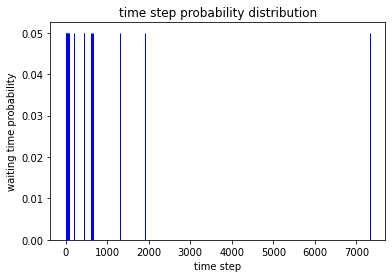

In [62]:
t_dif_size = max(dif)+1
time_array=np.arange(0, t_dif_size, 1).tolist()
count = [0]*(t_dif_size)
for i in range(t_dif_size):
    count[i]=dif.count(i)/len(Adj)
plt.bar(time_array,count,width=1,edgecolor='blue')
plt.xlabel("time step")
plt.ylabel("waiting time probability")
plt.title("time step probability distribution")

Choose the time step interval to be time_slot that you want to sum the probabilities from above graph.

Text(0.5, 1.0, 'probability of waiting time distribution')

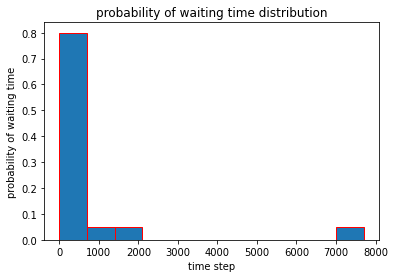

In [63]:
time_slot = 700
num_slots = int(len(count)/time_slot) +1
sum_counts = np.zeros(num_slots)
time_period = np.zeros(num_slots)
temp_p = np.linspace(0,num_slots*time_slot, num_slots+1)
count_appended = count
for i in range(num_slots*time_slot-len(count)):
    count_appended.append(0)

for i in range(num_slots):
    total = 0
    time_period[i]=(temp_p[i]+temp_p[i+1])*0.5
    for j in range(time_slot):
        index = i*time_slot + j
        total = total + count_appended[index]
    sum_counts[i]=total


plt.bar(time_period,sum_counts,width=time_slot,edgecolor='red')
plt.xlabel('time step')
plt.ylabel('probability of waiting time')
plt.title('probability of waiting time distribution')

## Case 2: Synchronous update + Random probabilistic variable (Stochastics)

In [69]:
dt= 0.00001 #timestep
beta = 0.3 #constant infectious rate

#Ini=random.randint(0, len(Adj)-1) #randomly chose 1 node in the whole network
#print('random chose node number',Ini,'to be 100% infectious')
#print('the node degree for this random chosen node is',G.degree(Ini))

Text(0, 0.5, 'total infectious people')

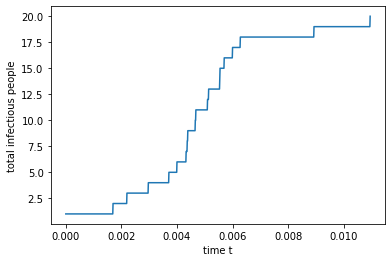

In [70]:
prb_infec = [0] * len(Adj)      
prb_infec[Ini]=1   
time_step = 0
seq = [0]*1
temp = [0]*len(Adj)

while min(prb_infec)<1:
    time_step = time_step+1
    random_nodes = random.sample(range(0, (len(Adj))), (len(Adj)))
    for i in range(len(Adj)):
        node_number = random_nodes[i]
        if prb_infec[node_number]==1:
            temp[node_number]=1 
        elif prb_infec[node_number]!=1:
            influence = 0
            for j in range(len(Adj)):
                influence = influence + (Adj[node_number,j]*prb_infec[j])
            temp[node_number]= prb_infec[node_number]+ (beta*(1-prb_infec[node_number])*influence*dt)
            monte = random.random()
            if monte <= temp[node_number] and node_number!=Ini:      #if it fall in to this certain probability,
                temp[node_number]=1             #we turn the node to be at 'infected' state
                seq.append(time_step)
            
            if temp[node_number] > 1 and node_number!=Ini:            #in some rare cases, where delta t is large,
                temp[node_number]=1              #influence from its neighbors is capable  
                seq.append(time_step)            #bringing one node directly have more than 
                                                 #100% probability of infectious rate
                    
    for i in range(len(Adj)):                                      
        prb_infec[i]=temp[i]           
        #update all node's probability of infectious at the end of 
        #one time step. Will accumulate the probability of infectious 
        #for those nodes whose randomly generated monte constant not
        #fall in their corresponding infectious probability. 
        #Will throw away nodes whose probability of infectious is 100%.

t_size = max(seq)+1
time_array=np.arange(0, t_size*dt, dt).tolist()
count = [-1]*(t_size)
for i in range(t_size):
    count[i]=seq.count(i) 
sum = 0
for i in range(len(count)):
    count[i]=count[i]+sum
    sum = count[i]
plt.plot(time_array,count)
plt.xlabel("time t")
plt.ylabel("total infectious people")

Compute waiting time of getting newly infected people, and compute 
variance & expectation^2 (they should be same is the distribution were exponential)

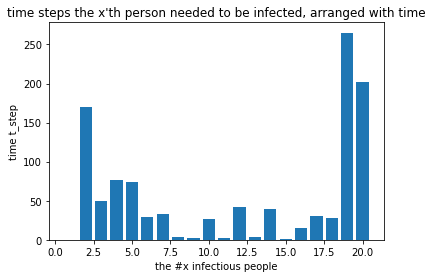

variance of waiting time is 5.483356725146199e-07
expectation^2 of waiting time is 3.321398891966759e-07


In [71]:
nodes = list(range(1, len(Adj)+1))
dif= [0]
for i in range(len(Adj)-1):
    time_dif = seq[i+1]-seq[i]
    dif.append(time_dif)
his = (nodes,dif)
plt.bar(*his)
plt.ylabel("time t_step")
plt.xlabel("the #x infectious people")
plt.title("time steps the x'th person needed to be infected, arranged with time")
plt.show()
if dif.count(0) >1:
    print("more than one event occur at one time step, shrink dt and try again")
dif.remove(0)

time_list = np.zeros(len(dif)) 
for i in range(len(dif)):
    time_list[i]=dif[i]*dt
expt = statistics.mean(time_list)
var = statistics.variance(time_list)
print( 'variance of waiting time is',var)
print('expectation^2 of waiting time is',expt*expt)

Compute the probability of waiting time distribution:

Text(0.5, 1.0, 'time step probability distribution')

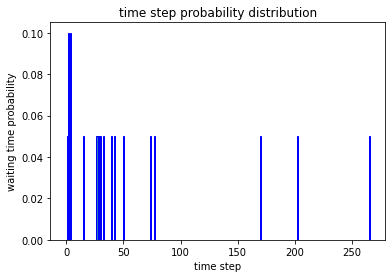

In [75]:
t_dif_size = max(dif)+1
time_array=np.arange(0, t_dif_size, 1).tolist()
count = [0]*(t_dif_size)
for i in range(t_dif_size):
    count[i]=dif.count(i)/len(Adj)
plt.bar(time_array,count,width=1,edgecolor='blue')
plt.xlabel("time step")
plt.ylabel("waiting time probability")
plt.title("time step probability distribution")

Choose the time step interval to be time_slot that you want to sum the probabilities from above graph.

Text(0.5, 1.0, 'probability of waiting time distribution')

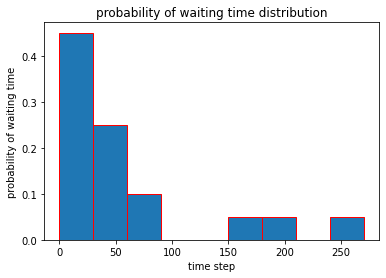

In [73]:
time_slot = 30
num_slots = int(len(count)/time_slot) +1
sum_counts = np.zeros(num_slots)
time_period = np.zeros(num_slots)
temp_p = np.linspace(0,num_slots*time_slot, num_slots+1)
count_appended = count
for i in range(num_slots*time_slot-len(count)):
    count_appended.append(0)

for i in range(num_slots):
    total = 0
    time_period[i]=(temp_p[i]+temp_p[i+1])*0.5
    for j in range(time_slot):
        index = i*time_slot + j
        total = total + count_appended[index]
    sum_counts[i]=total


plt.bar(time_period,sum_counts,width=time_slot,edgecolor='red')
plt.xlabel('time step')
plt.ylabel('probability of waiting time')
plt.title('probability of waiting time distribution')

## Case 3: Asynchronous update + Fixed threshold (Stochastics)

In [76]:
dt= 0.01 #timestep
beta = 0.9 #constant infectious rate
threshold = 0.1 #threshold 
                #If node k's proability of being infectious is over the threshold,
                #we consider node k is 100% infectious.
        
#Ini=random.randint(0, len(Adj)-1) #randomly chose 1 node in the whole network
#print('random chose node number',Ini,'to be 100% infectious')
#print('the node degree for this random chosen node is',G.degree(Ini))

Randomly choose one node to update at each time step. 
This could be long and if it keeps running for 3 minutes, I will just pause and rerun the cell below.

Text(0, 0.5, 'total infectious people')

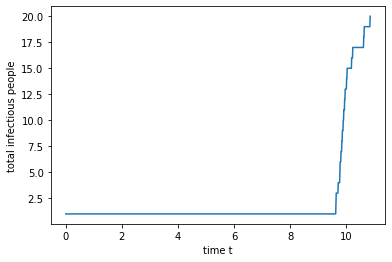

In [80]:
prb_infec = [0] * len(Adj)      
prb_infec[Ini]=1   
time_step = 0
seq = [0]*1
temp = [0]*len(Adj)


time_step = 0
seq = [0]*1
temp = [0]*len(Adj)
while min(prb_infec)<threshold:
    time_step = time_step+1
    node_number = random.randrange(len(Adj)) 
    if prb_infec[node_number]==1:
        temp[node_number]=1 
    elif prb_infec[node_number]!=1:
        influence = 0
        for j in range(len(Adj)):
            influence = influence + (Adj[node_number,j]*prb_infec[j])
        temp[node_number]= prb_infec[node_number]+ (beta*(1-prb_infec[node_number])*influence*dt)
    
        if temp[node_number] > threshold and node_number!=Ini:     
            temp[node_number]=1             
            seq.append(time_step)                          
    for i in range(len(Adj)):                                      
        prb_infec[i]=temp[i]           
        #update all node's probability of infectious at the end of 
        #one time step. Will throw away nodes whose probability
        #of infectious is 100%.
        
t_size = max(seq)+1
time_array=np.arange(0, t_size*dt, dt).tolist()
count = [-1]*(t_size)
for i in range(t_size):
    count[i]=seq.count(i) 
sum = 0
for i in range(len(count)):
    count[i]=count[i]+sum
    sum = count[i]
plt.plot(time_array,count)
plt.xlabel("time t")
plt.ylabel("total infectious people")

Compute waiting time of getting newly infected people, and compute 
variance & expectation^2 (they should be same is the distribution were exponential)

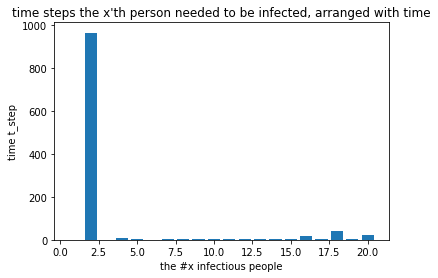

variance of waiting time is 4.831247368421054
expectation^2 of waiting time is 0.32670249307479227


In [81]:
nodes = list(range(1, len(Adj)+1))
dif= [0]
for i in range(len(Adj)-1):
    time_dif = seq[i+1]-seq[i]
    dif.append(time_dif)
his = (nodes,dif)
plt.bar(*his)
plt.ylabel("time t_step")
plt.xlabel("the #x infectious people")
plt.title("time steps the x'th person needed to be infected, arranged with time")
plt.show()
if dif.count(0) >1:
    print("more than one event occur at one time step, shrink dt and try again")
dif.remove(0)

time_list = np.zeros(len(dif)) 
for i in range(len(dif)):
    time_list[i]=dif[i]*dt
expt = statistics.mean(time_list)
var = statistics.variance(time_list)
print( 'variance of waiting time is',var)
print('expectation^2 of waiting time is',expt*expt)

Compute the probability of waiting time distribution:

Text(0.5, 1.0, 'time step probability distribution')

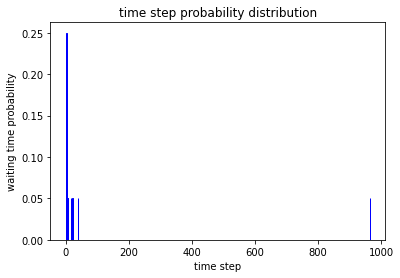

In [82]:
t_dif_size = max(dif)+1
time_array=np.arange(0, t_dif_size, 1).tolist()
count = [0]*(t_dif_size)
for i in range(t_dif_size):
    count[i]=dif.count(i)/len(Adj)
plt.bar(time_array,count,width=1,edgecolor='blue')
plt.xlabel("time step")
plt.ylabel("waiting time probability")
plt.title("time step probability distribution")

Choose the time step interval to be time_slot that you want to sum the probabilities from above graph.

Text(0.5, 1.0, 'probability of waiting time distribution')

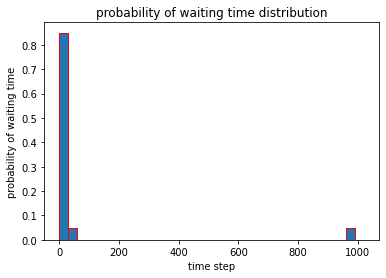

In [86]:
time_slot = 30
num_slots = int(len(count)/time_slot) +1
sum_counts = np.zeros(num_slots)
time_period = np.zeros(num_slots)
temp_p = np.linspace(0,num_slots*time_slot, num_slots+1)
count_appended = count
for i in range(num_slots*time_slot-len(count)):
    count_appended.append(0)

for i in range(num_slots):
    total = 0
    time_period[i]=(temp_p[i]+temp_p[i+1])*0.5
    for j in range(time_slot):
        index = i*time_slot + j
        total = total + count_appended[index]
    sum_counts[i]=total


plt.bar(time_period,sum_counts,width=time_slot,edgecolor='red')
plt.xlabel('time step')
plt.ylabel('probability of waiting time')
plt.title('probability of waiting time distribution')

## Case 4: Asynchronous update (Stochastics)+ Random probabilistic variable (Stochastics)

This model usually takes a long long time to run because both decision updating process 
and making process depends on randomly generated numbers, and so far I only succeed 1 time.

In [87]:
dt= 0.1 #timestep
beta = 0.3 #constant infectious rate
threshold = 0.5 # Fixed threshold 
                #If node i's proability of being infectious is over the threshold,
                #we consider node i is 100% infectious.
        
#Ini=random.randint(0, len(Adj)-1) #randomly chose 1 node in the whole network
#print('random chose node number',Ini,'to be 100% infectious')
#print('the node degree for this random chosen node is',G.degree(Ini))

In [88]:
prb_infec = [0] * len(Adj)       
prb_infec[Ini]=1                  

time_step = 0
seq = [0]*1
temp = [0]*len(Adj)
while min(prb_infec)<1:
    time_step = time_step+1
    node_number = random.randrange(len(Adj))
    if prb_infec[node_number]==1:
        temp[node_number]=1 
    elif prb_infec[node_number]!=1:
        influence = 0
        for j in range(len(Adj)):
            influence = influence + (Adj[node_number,j]*prb_infec[j])
        
        temp[node_number]= prb_infec[node_number]+ (beta*(1-prb_infec[node_number])*influence*dt)
        monte = random.random()
        if monte <= temp[node_number] and node_number!=Ini:
            temp[node_number]=1
            seq.append(time_step)
            
        if temp[node_number] > 1 and node_number!=Ini:    #in some rare cases, where delta t is large,
            temp[node_number]=1                           #influence from its neighbors is capable
            seq.append(time_step)                         #bringing one node directly have more than
                                                          #100% probability of infectious rate
    for i in range(len(Adj)):                                      
        prb_infec[i]=temp[i] 
        
t_size = max(seq)+1
time_array=np.arange(0, t_size*dt, dt).tolist()
count = [-1]*(t_size)
for i in range(t_size):
    count[i]=seq.count(i) 
sum = 0
for i in range(len(count)):
    count[i]=count[i]+sum
    sum = count[i]
plt.plot(time_array,count)

KeyboardInterrupt: 

In [ ]:
nodes = list(range(1, len(Adj)+1))
dif= [0]
for i in range(len(Adj)-1):
    time_dif = seq[i+1]-seq[i]
    dif.append(time_dif)
his = (nodes,dif)
plt.bar(*his)
plt.ylabel("time t_step")
plt.xlabel("the #x infectious people")
plt.title("time steps the x'th person needed to be infected, arranged with time")
plt.show()
if dif.count(0) >1:
    print("more than one event occur at one time step, shrink dt and try again")
dif.remove(0)

time_list = np.zeros(len(dif)) 
for i in range(len(dif)):
    time_list[i]=dif[i]*dt
expt = statistics.mean(time_list)
var = statistics.variance(time_list)
print( 'variance of waiting time is',var)
print('expectation^2 of waiting time is',expt*expt)

In [ ]:
t_dif_size = max(dif)+1
time_array=np.arange(0, t_dif_size, 1).tolist()
count = [0]*(t_dif_size)
for i in range(t_dif_size):
    count[i]=dif.count(i)/len(Adj)
plt.bar(time_array,count,width=1,edgecolor='blue')
plt.xlabel("time step")
plt.ylabel("waiting time probability")
plt.title("time step probability distribution")

In [ ]:
time_slot = 30
num_slots = int(len(count)/time_slot) +1
sum_counts = np.zeros(num_slots)
time_period = np.zeros(num_slots)
temp_p = np.linspace(0,num_slots*time_slot, num_slots+1)
count_appended = count
for i in range(num_slots*time_slot-len(count)):
    count_appended.append(0)

for i in range(num_slots):
    total = 0
    time_period[i]=(temp_p[i]+temp_p[i+1])*0.5
    for j in range(time_slot):
        index = i*time_slot + j
        total = total + count_appended[index]
    sum_counts[i]=total


plt.bar(time_period,sum_counts,width=time_slot,edgecolor='red')
plt.xlabel('time step')
plt.ylabel('probability of waiting time')
plt.title('probability of waiting time distribution')

In [ ]:
def plot_degree_dist(Adj):
    degrees = np.zeros(len(Adj))
    for 
    
    
node_degrees = np.zeros(max(dist))
for i in range(len(Am)):
    index = dist[i]
    node_degrees[index] = node_degrees[index]+1
nodes1= np.linspace(1,max(dist),max(dist))
plt.bar(nodes1,node_degrees )